In [2]:
import adage
from adage import adagetask

In [3]:
@adagetask
def preparegrid(workdir):
    #prepare run card
    from string import Template
    with open('input/run_card.templ') as f:
        t = Template(f.read()).substitute(
            gridpack = True,
            nevents = 1,
            seed = 1234,
            sqrts_half = 40.0,
            polbeam1 = 100,
            polbeam2 = -100,
        )
        runcardfilename = '{}/run_card.dat'.format(workdir)
        with open(runcardfilename,'w') as runcard:
            runcard.write(t)
            
    #prepare steering file
    steeringfilename = '{}/steer.dat'.format(workdir)
    with open(steeringfilename,'w') as steeringfile:
        steeringfile.write(
'''
import model sm
generate e+ e- > mu+ mu-
output {output}
launch -n output
{runcard}
quit
'''.format(
        output = '{}/gridpack'.format(workdir),
        runcard = runcardfilename,
            )
        )
    import subprocess
    subprocess.check_call(['mg5','-f',steeringfilename])
    
        

In [15]:
@adagetask
def generate(workdir,genworkdir,seed,nevents):
    os.makedirs(genworkdir)
    gridpackfile = '{}/gridpack/output_gridpack.tar.gz'.format(workdir)
    import tarfile
    t = tarfile.open(gridpackfile)
    t.extractall(path = genworkdir)
    import subprocess
    import shlex
    subprocess.check_call(shlex.split('./run.sh {} {}'.format(nevents,seed)), cwd = genworkdir)

In [16]:
@adagetask
def merge(workdir,genworkdirs):
    infiles = ['{}/events.lhe.gz'.format(x) for x in genworkdirs]
    import jsonlines
    import pylhe
    import gzip
    outfile = '{}/merged.jsonl'.format(workdir)
    with jsonlines.open(outfile,'w') as writer:
        for f in infiles:
            for e in pylhe.readLHE(gzip.open(f)):
                writer.write(e)

In [26]:
workdir = 'workdir'

import os
import shutil
if os.path.exists(workdir):
    shutil.rmtree(workdir)

seeds = [1,2,3,4]
workflow = adage.adageobject()

n_prepgrid = workflow.dag.addTask(preparegrid.s(workdir = workdir))

evgen_nodes = []
genworkdirs = []
for i,x in enumerate(seeds):
    genworkdir = '{}/gen_{}'.format(workdir,i)
    genworkdirs.append(genworkdir)
    evgen_nodes.append(
        workflow.dag.addTask(generate.s(workdir = workdir, seed = x, genworkdir = genworkdir, nevents = 10000),
                             depends_on = [n_prepgrid])
    )

n_merge = workflow.dag.addTask(merge.s(workdir = workdir,genworkdirs = genworkdirs), depends_on = evgen_nodes)

In [29]:
import adage.backends
backend = adage.backends.MultiProcBackend(4)
adage.rundag(workflow, default_trackers = True, workdir = workdir, backend = backend)

In [30]:
%pylab
%matplotlib inline
import jsonlines

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [31]:
inputfile = '{}/merged.jsonl'.format(workdir)
costhetas = []
for i,e in enumerate(jsonlines.Reader(open(inputfile))):
    els = [p for p in e['particles'] if p['id'] == 11]
    mus = [p for p in e['particles'] if p['id'] == 13]
    assert len(mus) == 1
    assert len(els) == 1
    mu = mus[0]
    el = els[0]
    el_px, el_py, el_pz = [el[x] for x in ['px','py','pz']]
    mu_px, mu_py, mu_pz = [mu[x] for x in ['px','py','pz']]
    costheta = mu_pz/el_pz
    costhetas.append(costheta)

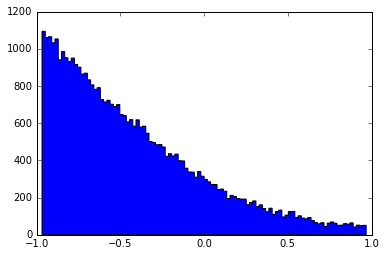

In [32]:
_,_,_ = plt.hist(costhetas, bins = 100, histtype='stepfilled')